In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap

# load data and model
X_train = pd.read_csv('../data/modeling/X_train.csv')
y_train = pd.read_csv('../data/modeling/y_train.csv').values.ravel()

model = joblib.load('../models/logistic_regression.pkl')
scaler = joblib.load('../models/scaler.pkl')

X_train_scaled = scaler.transform(X_train.fillna(X_train.median()))

print(f"Features: {X_train.shape[1]}")

/Users/anasputhawala/anaconda3/lib/python3.11/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.4' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/anasputhawala/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Features: 62


## Logistic Regression Coefficients

For logistic regression, coefficients show directional impact:
Positive coefficient increases enrollment probability
Negative coefficient decreases enrollment probability
Larger magnitude stronger influence

In [2]:
# coefficient importance
coefs = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

coefs.head(20)

,feature,coefficient
48,is_any_donor,1.850591
13,donor_political_org,-1.356293
47,n_donor_types,-0.713629
6,length_of_residence,0.694679
50,age_x_homeowner,0.323381
17,donor_health_org,0.286846
14,donor_liberal_org,0.209712
56,above_texas_median,0.148060
52,age_bin,0.135501
26,purchases_luxuryitems,0.131971


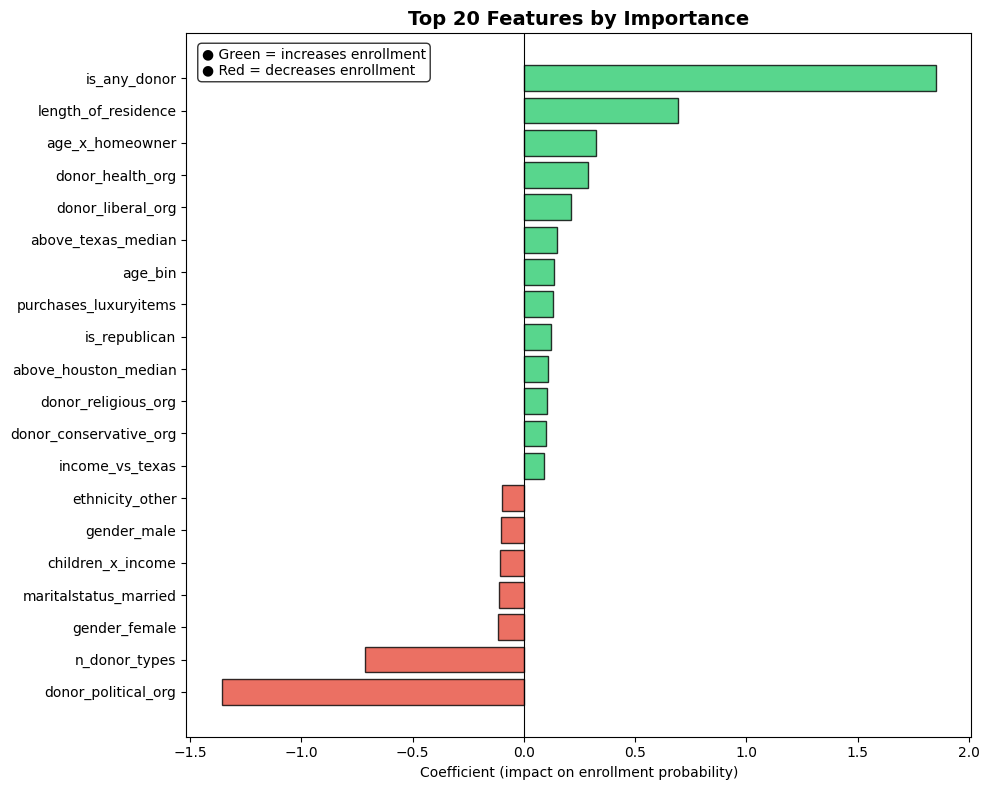

In [3]:
# top 20 features bar plot
top_n = 20
top_coefs = coefs.head(top_n).sort_values('coefficient')

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in top_coefs['coefficient']]
ax.barh(top_coefs['feature'], top_coefs['coefficient'], color=colors, edgecolor='black', alpha=0.8)

ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Coefficient (impact on enrollment probability)')
ax.set_title('Top 20 Features by Importance', fontsize=14, fontweight='bold')

# add a simple legend
ax.text(0.02, 0.98, '● Green = increases enrollment\n● Red = decreases enrollment', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('../output/feature_importance_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

## SHAP Values

SHAP (SHapley Additive exPlanations) gives us a more nuanced view:
- Shows how each feature pushes predictions up or down
- Accounts for feature interactions
- More interpretable for stakeholders

In [4]:
# compute SHAP values (using a sample for speed)
sample_size = 1000
sample_idx = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)
X_sample = X_train_scaled[sample_idx]

explainer = shap.LinearExplainer(model, X_sample)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed for {sample_size} samples.")

SHAP values computed for 1000 samples.


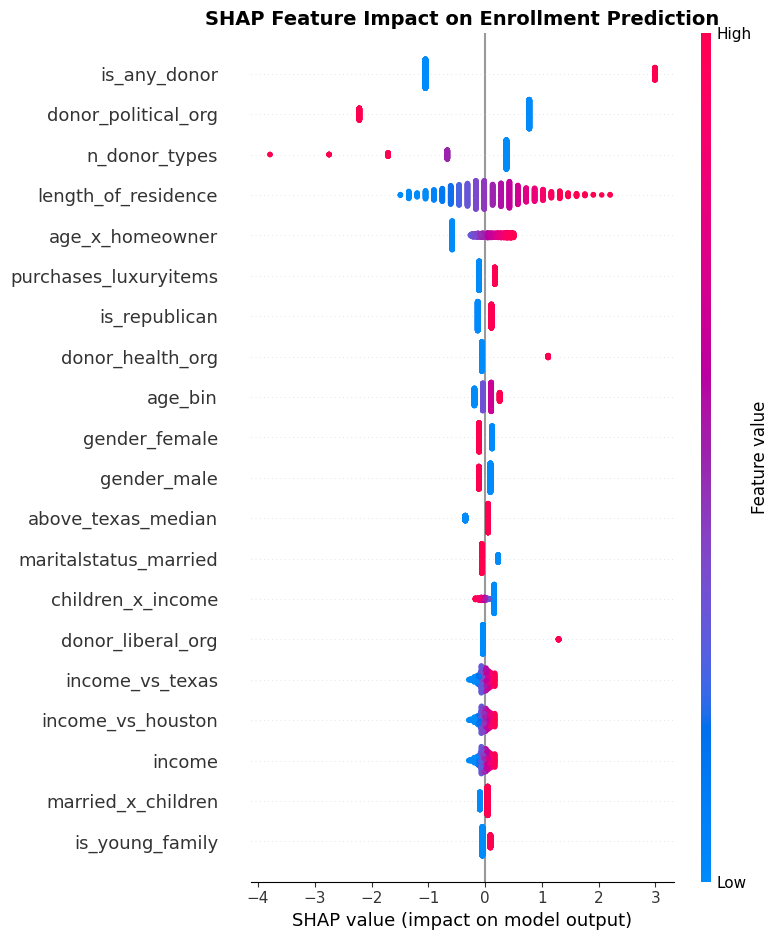

In [5]:
# SHAP summary plot (beeswarm)
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_sample, feature_names=X_train.columns, show=False, max_display=20)
plt.title('SHAP Feature Impact on Enrollment Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
plt.savefig('../output/shap_summary.png', dpi=150, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## Key Drivers Summary

For the release notes - plain english summary of what drives enrollment.

In [8]:
# mean absolute SHAP by feature
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("Top 15 Enrollment Drivers:")
for i, row in shap_importance.head(15).iterrows():
    print(f"{row['feature']:<30} {row['mean_abs_shap']:.4f}")

Top 15 Enrollment Drivers:
is_any_donor                   1.6272
donor_political_org            1.1939
n_donor_types                  0.5612
length_of_residence            0.5563
age_x_homeowner                0.2797
purchases_luxuryitems          0.1291
is_republican                  0.1216
donor_health_org               0.1205
age_bin                        0.1179
gender_female                  0.1130
gender_male                    0.1003
above_texas_median             0.0971
maritalstatus_married          0.0924
children_x_income              0.0890
donor_liberal_org              0.0727


In [10]:
# which features increase vs decrease enrollment?
positive_drivers = coefs[coefs['coefficient'] > 0].head(10)
negative_drivers = coefs[coefs['coefficient'] < 0].head(10)

print("\nFeatures that drive the model to predict enrollment:")

for _, row in positive_drivers.iterrows():
    print(f"  + {row['feature']}")

print(f'---')
for _, row in negative_drivers.iterrows():
    print(f"  - {row['feature']}")


Features that drive the model to predict enrollment:
  + is_any_donor
  + length_of_residence
  + age_x_homeowner
  + donor_health_org
  + donor_liberal_org
  + above_texas_median
  + age_bin
  + purchases_luxuryitems
  + is_republican
  + above_houston_median
---
  - donor_political_org
  - n_donor_types
  - gender_female
  - maritalstatus_married
  - children_x_income
  - gender_male
  - ethnicity_other
  - is_independent
  - education_level
  - is_democrat
